# Fates Plant Trait Ensemble Evaluation Against Observations at BCI

The purpose of this testbed code is to compare FATES output to observations at BCI and select ensemble members that best match the observations. This specific version of the code compares the performance of Fates with and without an SLA profile. The analysis can be repeated for the same simulations at two CO2 levels (367 and 400ppm) using the "setcase" toggle in the "Set case,..." box below. These CO2 levels represent the approximate CO2 concentrations at the beginning and end of the observational period.

# Load libraries

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import scipy
from scipy import stats
from scipy.stats import pearsonr

# set the plot style
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, "lines.markersize": 6.0, 'lines.markeredgewidth': 1.0})


# Load data

In [4]:
# We chose to run at two CO2 levels as they bound the CO2 concentration over the observational time period

# Set file paths and names
filename_modeloutput_367ppm = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_367ppm_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h0.ensemble.sofar.nc'
filename_modeloutput_400ppm = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_400ppm_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h0.ensemble.sofar.nc'
filename_parameters = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/fates_params_8c32468_bcitraits_test01_v_ensemble.c180605.nc'
filename_observations_fluxes = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/BCI_v3.1.csv'
filename_observations_lai = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/LAI_Detto2018Obs.csv'
filename_observations_biomass = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/BCI_biomass.csv'
filename_observations_basalarea = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/census_bmks_bci_171208.nc'


# Load data
data_modeloutput_367ppm = nc4.Dataset(filename_modeloutput_367ppm)
data_modeloutput_400ppm = nc4.Dataset(filename_modeloutput_400ppm)
data_parameter_values = nc4.Dataset(filename_parameters)
data_observations_fluxes = np.genfromtxt(filename_observations_fluxes, dtype={'names': ('date','tair','RH','vpd','p_kpa','PPT','Rs','Rs_dn','Rl_dn','Rl_up','Rnet','LE','H','Par_tot','Par_diff','SWC','ubar','ustar','WD','gpp','FLAG'),'formats': ('S16','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4')}, delimiter=',', skip_header=2)

#### Load data here for lai, biomass, basalarea ?


# Create timeseries of annual means for analysis

#### For model output

In [8]:
# Set some basic parameters
sample_var = histfile0.variables['GPP']
nens = sample_var.shape[0] # number of ensemble members
nts = sample_var.shape[1] # number of months
nyears = nts/12 # number of years
startyear = nyears-50 # analyzing 50 years, this is the startyear indx (e.g. for a 300 year run, startyear = 250, actual run year it calls = 251)
endyear = nyears # this is the endyear indx (e.g. for a 300 year run, endyear = 300, which corresponds to run year 301 but, 
                                    # when used as endmember in [startyear:endyear] python does not actually call year 301, it calls up to and including year 300)
                                    # Thus, endyear - startyear = 50 years; and [startyear:endyear] calls 50 years (years 251-300 in a 300 year run)

# Monthly Timeseries 
# starting with Jun of startyear to May of endyear because the ensemble runs start in June
fe_gpp_mthts = histfile0.variables['GPP'][:,int(startyear*12):int(endyear*12),0] * 86400 *365
fe_h_mthts = histfile0.variables['FSH'][:,int(startyear*12):int(endyear*12),0]
fe_le_mthts = (histfile0.variables['FCTR'][:,int(startyear*12):int(endyear*12),0]
+histfile0.variables['FGEV'][:,int(startyear*12):int(endyear*12),0]
+histfile0.variables['FCEV'][:,int(startyear*12):int(endyear*12),0])
fe_lai_mthts = histfile0.variables['TLAI'][:,int(startyear*12):int(endyear*12),0]

# Monthly Timeseries by Year
# starting in June because started model simulations at 0001-06
fe_gpp_yrmth = np.reshape(fe_gpp_mthts,(nens,-1,12))
fe_h_yrmth = np.reshape(fe_h_mthts,(nens,-1,12))
fe_le_yrmth = np.reshape(fe_le_mthts,(nens,-1,12))
fe_lai_yrmth = np.reshape(fe_lai_mthts,(nens,-1,12))

# Annual Mean Timeseries
fe_gpp_annmeants = np.nanmean(fe_gpp_yrmth,axis=2) 
fe_h_annmeants = np.nanmean(fe_h_yrmth,axis=2) 
fe_le_annmeants = np.nanmean(fe_le_yrmth,axis=2)
fe_lai_annmeants = np.nanmean(fe_lai_yrmth,axis=2)

# Annual Value Timeseries
# Load agb by size class, then sum across size classes
fe_agb_annts = np.squeeze(np.nansum((histfile1.variables['AGB_SCLS'][:,int(startyear):int(endyear),:]),axis=2)) # kgC/m2
fe_ba_annts = np.squeeze(np.nansum((histfile1.variables['BA_SCLS'][:,int(startyear):int(endyear),:]),axis=2)) # m2/ha


#### For observations

In [3]:
# Load observations for GPP, LH, SH
# This results in arrays with shape(6,12) for:
# gpp_gcm2y = timeseries of monthly mean gpp (gC/m2/yr); averaged across all 30min time points for each month)
# LE_monthyear = timeseries of monthly mean latent heat flux(W/m2);
# H_monthyear = timeseries of monthly mean sensible heat flux (W/m2);

#bci_fluxtower_datafilename = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/BCI_v3.1.csv'

#bci_fluxtower_data = np.genfromtxt(bci_fluxtower_datafilename, dtype={'names': ('date','tair','RH','vpd','p_kpa','PPT','Rs','Rs_dn','Rl_dn','Rl_up','Rnet','LE','H','Par_tot','Par_diff','SWC','ubar','ustar','WD','gpp','FLAG'),'formats': ('S16','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4','f4')}, delimiter=',', skip_header=2)

ntim = len(bci_fluxtower_data)

time_start = datetime.datetime(2010, 1, 1, 0, 00)

tdelt = np.ma.masked_all(ntim)
month = np.ma.masked_all(ntim, dtype=np.int)
year = np.ma.masked_all(ntim, dtype=np.int)
gpp = np.ma.masked_all(ntim)
LE = np.ma.masked_all(ntim)
H = np.ma.masked_all(ntim)

for i in range(ntim):
    ts = dateutil.parser.parse(bci_fluxtower_data[i][0])
    tdelt[i] = (ts - time_start).days + (ts - time_start).seconds / 86400.
    month[i] = ts.month
    year[i] = ts.year
    gpp[i] = bci_fluxtower_data[i][19]
    LE[i] = bci_fluxtower_data[i][11]
    H[i] = bci_fluxtower_data[i][12]

H_masked = np.ma.masked_invalid(H)

nyears = (year.max() - year.min()) + 1
nmonths = nyears * 12

gpp_monthly = np.ma.masked_all(nmonths)
gpp_monthyear = np.ma.masked_all([nyears,12])
LE_monthyear = np.ma.masked_all([nyears,12])
H_monthyear = np.ma.masked_all([nyears,12])

for i in range(nyears):
    for j in range(12):
        mask = (year[:] == (year.min() + i)) * (month[:] == (j + 1))
        index = i*12 + j
        # gpp_monthly2[index] = gpp[mask].mean()                                                                                                                                                                                                                              
        if mask.sum() > 0:
            gpp_monthly[index] = (gpp * mask).sum() / mask.sum()
            gpp_monthyear[i,j] = gpp_monthly[index]
            LE_monthyear[i,j] = (LE * mask).sum() / mask.sum()
        H_monthyear[i,j] = H_masked[mask].mean()

months = np.arange(12)

### change gpp units to grams or carbon per meter squared per year
gpp_gcm2y = gpp_monthyear * 1e-6 * 12.0107 * (86400 * 365.25)

In [4]:
# Load observations for LAI
# LAI_monthyear = timeseries of monthly LAI (m2/m2) starting with January;
# Note: These are not monthly mean values, rather a snapshot approximately once a month. Means and sd are across 188 locations at BCI.
# Source: Detto et al. 2018, data captured from Fig 7a using GraphClick software

#bci_lai_datafilename = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/LAI_Detto2018Obs.csv'

# Monthly Mean
lai_mthts = np.asarray([col[2] for col in (pd.read_csv(bci_lai_datafilename)).values])
# Monthly Means + 2*SD
lai_mthts_p2sd = lai_mthts + 2*(np.asarray([col[7] for col in (pd.read_csv(bci_lai_datafilename)).values]))
# Monthly Means - 2*SD
lai_mthts_m2sd = lai_mthts - 2*(np.asarray([col[7] for col in (pd.read_csv(bci_lai_datafilename)).values]))

# Calculate Annual Mean
# Two versions because have 2yrs+8mths
lai_annmean_janstart = np.nanmean(np.reshape(lai_mthts[:24],(2,12)),1) # Starting in Jan 
lai_annmean_septstart = np.nanmean(np.reshape(lai_mthts[8:24+8],(2,12)),1) # Starting in Sept

In [5]:
# Load observations for Carbon Biomass at BCI
# We use the the range across two different allometries (standard and Chave) from Meakem et al. 2018 (New Phytol) to bracket the overall uncertainty
    # because:  1) they are the most recent estimates; 2) they track only carbon, which is consistent with FATES output.
# However, using a carbon to biomass ratio of 1/2, the census data give a similar range for Mg C/ha.

#bci_biomass_datafilename = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/BCI_biomass.csv'

# Total aboveground biomass (Mg biomass/ha) from census data (Baraloto et al. 2013, Biotropica; Feeley et al. 2007, Proc Roy Soc B)
# Years: 2005,1985,1990,1995,2000,2005
agb_biomass_obs = np.asarray([col[1] for col in (pd.read_csv(bci_biomass_datafilename)).values])[:-2,]
# Estimate of carbon biomass from biomass using scaler of 0.47 following Meakem et al. 2018
est_agb_cbiomass = agb_biomass_obs*0.47

# Carbon aboveground biomas (Mg C/ha) from Meakem et al. 2018 New Phytol
cbiomass_obs_Mgha = np.asarray([col[2] for col in (pd.read_csv(bci_biomass_datafilename)).values])[-2:,]
# Convert from MgC/ha to KgC/m2
ha_to_m2 = 1/10000
Mg_to_kg = 1000
agb_cbiomass_obs = cbiomass_obs_Mgha * ha_to_m2 * Mg_to_kg

In [6]:
# Load observations for Basal Area at BCI
# Use only the last 5 of the 7 census dates, as the first 2 dates used a different measurment method

#filename_ba = '/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/benchmark_datasets/census_bmks_bci_171208.nc'

# Basal Area (m2/ha)
bafile = nc4.Dataset(filename_ba)
basalarea_bysize = bafile.variables['basal_area_by_size_census'][2:,:,:] # (census number, diameter size class, confidence (0.05,0.5,0.95))
basalarea_obs_wlimits = np.nansum(basalarea_bysize,1) #sum across size classes
# basalarea_obs_wlimits = [lowerlimit, mean, upperlimit] for each census, where limits are range across locations
basalarea_obs = basalarea_obs_wlimits[:,1] # this is the mean basal area value for the whole census site, which we use in this analysis
#basalarea_llimit = basalarea_obs[:,0]
#basalarea_ulimit = basalarea_obs[:,2]

#### Calculate Annual Mean for Observations

In [7]:
# varname_annmean_julystart = 5 annual means starting in July (because observations start in July)
# varname_annmean_septstart = 5 annual means starting in Sept (because observations end in Aug)

# Version 1: Calculate annual means starting in July (because obs start in July)
dif = 6 # throw out first 6 months of the timeseries (they are blank)

var = gpp_gcm2y
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
gpp_annmean_julystart = var_annmean_difstart
print(gpp_annmean_julystart)

var = LE_monthyear
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
le_annmean_julystart = var_annmean_difstart
print(le_annmean_julystart)

var = H_monthyear
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
h_annmean_julystart = var_annmean_difstart
print(h_annmean_julystart)

# Version 2: calculate annual means starting in Sept (because observations end in Aug)
dif = 8 # throw out first 8 months of the timeseries to use the entirety of the last 5 years of the timeseries

var = gpp_gcm2y
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
gpp_annmean_septstart = var_annmean_difstart
print(gpp_annmean_septstart)

var = LE_monthyear
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
le_annmean_septstart = var_annmean_difstart
print(le_annmean_septstart)

var = H_monthyear
var_mthts = np.reshape(var,(1,-1))
var_mthts.shape
var_mthts_difstart = var_mthts[:,dif:dif-12]
var_monthyear_difstart = np.reshape(var_mthts_difstart,(5,12))
var_annmean_difstart = np.nanmean(var_monthyear_difstart,1)
h_annmean_septstart = var_annmean_difstart
print(h_annmean_septstart)


[2737.08248638 2606.79367669 2851.81973399 2734.00238978 2630.37938588]
[75.15923775 74.14869518 74.04685262 71.71978421 80.87098177]
[31.69263887 32.11861236 33.35441726 34.00074938 26.18076703]
[2699.57753992 2676.46630416 2896.86514    2585.04462487 2718.64684473]
[74.69160531 74.68721632 72.74634217 73.13411425 77.34702377]
[31.30034201 33.55023009 33.06906925 32.63175809 23.49438212]


# Evaluate the skill of each SLA Profile Ensemble Member

# Skill Score Measure #1:  Pscore
Measures the % of model annual means that fall within observed range for each ensemble member.

The range is defined as the minimum and maximum across observations. We also trying a degraded observed range (10% and 20% in each direction) to account for measurement error.


In [10]:
# Calculate pscore for each variable [using observed range, observed range with 10% degradation, observed range with 20% degradation]

#Pscore Calculation
#pscore[:,0] = pscore for observed range; 
#pscore[:,1] = pscore for observed range degraded by 10%; 
#pscore[:,2] = pscore for observed range degraded by 20%;
def pscore_calc(ens_ts,obs_min,obs_max,nens,startyear,endyear):
    #Where ens_ts = fates ensemble members time series
    #Degrade observed range:
    dg1 = 0.10
    dg2 = 0.20
    obsmin = np.stack((obs_min,(1-dg1)*obs_min,(1-dg2)*obs_min),axis = 0)
    obsmax = np.stack((obs_max,(1+dg1)*obs_max,(1+dg2)*obs_max),axis = 0)
    #Calculate pscores for observed and degraded ranges
    pscore = np.ma.masked_all([nens,3])
    test_ann_range = np.ma.masked_all([nens,3])
    for i in range(nens):
        for j in range(3):
            n = endyear-startyear
            test_ann_range[i,j] = (ens_ts[i,:] < obsmin[j]).sum()+(ens_ts[i,:] > obsmax[j]).sum()
            pscore[i,j] = 100 - 100*test_ann_range[i,j]/(n)
    return pscore

# Leaf Area Index
lai_annmean_min = np.nanmin(np.stack((lai_annmean_janstart,lai_annmean_septstart), axis = 1))
lai_annmean_max = np.nanmax(np.stack((lai_annmean_janstart,lai_annmean_septstart), axis = 1))
pscore_lai = pscore_calc(fe_lai_annmeants,lai_annmean_min,lai_annmean_max,nens,startyear,endyear)

# Aboveground Biomass (kgC/m2)
agb_min = np.nanmin(agb_cbiomass_obs)
agb_max = np.nanmax(agb_cbiomass_obs)
pscore_agb = pscore_calc(fe_agb_annts,agb_min,agb_max,nens,startyear,endyear)

# Basal Area (m2/ha)
ba_min = np.nanmin(basalarea_obs)
ba_max = np.nanmax(basalarea_obs)
pscore_ba = pscore_calc(fe_ba_annts,ba_min,ba_max,nens,startyear,endyear)

# GPP
gpp_annmean_min = np.nanmin(np.stack((gpp_annmean_julystart,gpp_annmean_septstart), axis = 1))
gpp_annmean_max = np.nanmax(np.stack((gpp_annmean_julystart,gpp_annmean_septstart), axis = 1))
pscore_gpp= pscore_calc(fe_gpp_annmeants,gpp_annmean_min,gpp_annmean_max,nens,startyear,endyear)

# Latent heat
le_annmean_min = np.nanmin(np.stack((le_annmean_julystart,le_annmean_septstart), axis = 1))
le_annmean_max = np.nanmax(np.stack((le_annmean_julystart,le_annmean_septstart), axis = 1))
pscore_le = pscore_calc(fe_le_annmeants,le_annmean_min,le_annmean_max,nens,startyear,endyear)

# Sensible heat
h_annmean_min = np.nanmin(np.stack((h_annmean_julystart,h_annmean_septstart), axis = 1))
h_annmean_max = np.nanmax(np.stack((h_annmean_julystart,h_annmean_septstart), axis = 1))
pscore_h = pscore_calc(fe_h_annmeants,h_annmean_min,h_annmean_max,nens,startyear,endyear)

# Skill Score Measure #2:  Distance Score
Measures how far from the observed mean each ensemble member's annual means are, considering the range in observations

In [17]:
# Calculate Distance metric using Normalized Root Mean Square Error (RMSE/Observed Range)
# We use this version of the distance score in the analysis below

#Define distance metric
def dist_calc_rmse(nens,endyear,startyear,fe_ts,obs_ts):
    dist_score_rmse = np.ma.masked_all([nens,1])
    obs_min = min(obs_ts)
    obs_max = max(obs_ts)
    for i in range(nens):
        n = endyear-startyear
        dist_score_rmse[i,:] = np.sqrt(np.nansum((np.nanmean(obs_ts) - fe_ts[i,:])**2) / n)/(obs_max-obs_min)
    return dist_score_rmse

# Calculate Distance score for each variable
# LAI
dscore_lai_jan = dist_calc_rmse(nens,endyear,startyear,fe_lai_annmeants,lai_annmean_janstart)
dscore_lai_sept = dist_calc_rmse(nens,endyear,startyear,fe_lai_annmeants,lai_annmean_septstart)
# AGB   
dscore_agb = dist_calc_rmse(nens,endyear,startyear,fe_agb_annts,agb_cbiomass_obs)
# BA
dscore_ba = dist_calc_rmse(nens,endyear,startyear,fe_ba_annts,basalarea_obs)
#GPP    
dscore_gpp_jul = dist_calc_rmse(nens,endyear,startyear,fe_gpp_annmeants,gpp_annmean_julystart)
dscore_gpp_sept = dist_calc_rmse(nens,endyear,startyear,fe_gpp_annmeants,gpp_annmean_septstart)
#LH  
dscore_le_jul = dist_calc_rmse(nens,endyear,startyear,fe_le_annmeants,le_annmean_julystart)
dscore_le_sept = dist_calc_rmse(nens,endyear,startyear,fe_le_annmeants,le_annmean_septstart)
#SH
dscore_h_jul = dist_calc_rmse(nens,endyear,startyear,fe_h_annmeants,h_annmean_julystart)
dscore_h_sept = dist_calc_rmse(nens,endyear,startyear,fe_h_annmeants,h_annmean_septstart)

# Are Skill Scores Correlated Across Variables?
We would like to know if skill scores for individual variables are correlated with one another. This will inform decisions about combining skill scores for individual variables into a weighted average skill score across variables.

In [20]:
# Check if pscores are correlated across variables
dg10ind =1
pscore_matrix = np.transpose(np.stack([pscore_lai[:,dg10ind],pscore_agb[:,dg10ind],pscore_ba[:,dg10ind],pscore_gpp[:,dg10ind],pscore_le[:,dg10ind],pscore_h[:,dg10ind]],axis=0))
pscore_names = ['pscore_lai','pscore_agb','pscore_ba','pscore_gpp','pscore_le','pscore_h']
df = pd.DataFrame(pscore_matrix, columns = pscore_names)

# Generate Table of pearson's correlation coefficients and p-values
# df.corr() # generates matrix of correlation coefficients
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

# Calculate pvalues using the above function
calculate_pvalues(df)
# Indicate significance of pearson's r (*p<=0.05, **p<=0.001)
rho = df.corr()
pval = calculate_pvalues(df) # toto_tico's answer
# create three masks
r1 = rho.applymap(lambda x: '{:.2f}*'.format(x))
r2 = rho.applymap(lambda x: '{:.2f}**'.format(x))
r3 = rho.applymap(lambda x: '{:.2f}***'.format(x))
# apply them where appropriate --this could be a single liner
#rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r1)
rho = rho.mask(pval<=0.001,r2)
rho

,pscore_lai,pscore_agb,pscore_ba,pscore_gpp,pscore_le,pscore_h
pscore_lai,1.00**,0.091476,0.011264,0.111322,0.25**,0.0678806
pscore_agb,0.091476,1.00**,0.29**,0.15*,0.0847698,0.21**
pscore_ba,0.011264,0.29**,1.00**,0.18*,0.13*,0.13*
pscore_gpp,0.111322,0.15*,0.18*,1.00**,0.56**,0.43**
pscore_le,0.25**,0.0847698,0.13*,0.56**,1.00**,0.36**
pscore_h,0.0678806,0.21**,0.13*,0.43**,0.36**,1.00**


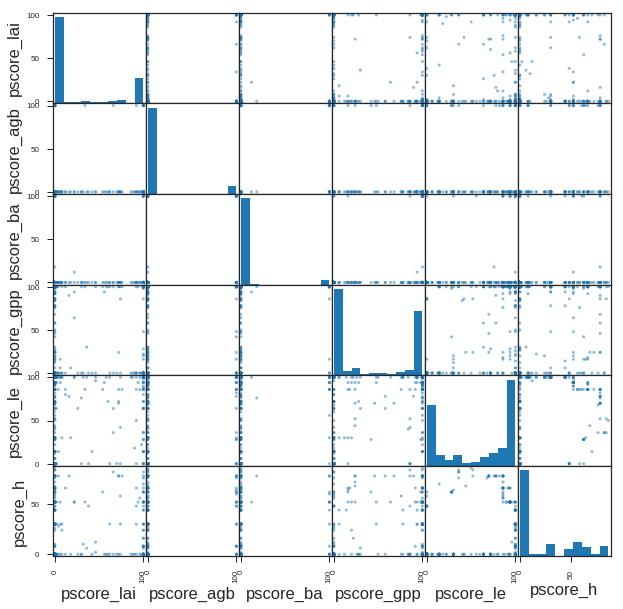

In [21]:
# View as scatter matrix
#pd.scatter_matrix(df, figsize=[10,10])
pd.plotting.scatter_matrix(df, figsize=[10,10])
plt.show()

In [22]:
# Check if dscores are correlated across variables
dscore_matrix = np.transpose(np.stack([dscore_lai_best,np.squeeze(dscore_agb),np.squeeze(dscore_ba),dscore_gpp_best,dscore_le_best,dscore_h_best],axis=0))
dscore_names = ['dscore_lai','dscore_agb','dscore_ba','dscore_gpp','dscore_le','dscore_h']
df = pd.DataFrame(dscore_matrix, columns = dscore_names)

# Generate Table of pearson's correlation coefficients and p-values
# df.corr() # generates matrix of correlation coefficients
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

# Calculate pvalues using the above function
calculate_pvalues(df)
# Indicate significance of pearson's r (*p<=0.05, **p<=0.001)
rho = df.corr()
pval = calculate_pvalues(df) # toto_tico's answer
# create three masks
r1 = rho.applymap(lambda x: '{:.2f}*'.format(x))
r2 = rho.applymap(lambda x: '{:.2f}**'.format(x))
r3 = rho.applymap(lambda x: '{:.2f}***'.format(x))
# apply them where appropriate --this could be a single liner
#rho = rho.mask(pval<=0.1,r1)
rho = rho.mask(pval<=0.05,r1)
rho = rho.mask(pval<=0.001,r2)
rho

,dscore_lai,dscore_agb,dscore_ba,dscore_gpp,dscore_le,dscore_h
dscore_lai,1.00**,0.45**,0.51**,0.84**,0.81**,0.71**
dscore_agb,0.45**,1.00**,0.89**,0.64**,0.47**,0.60**
dscore_ba,0.51**,0.89**,1.00**,0.69**,0.54**,0.63**
dscore_gpp,0.84**,0.64**,0.69**,1.00**,0.88**,0.82**
dscore_le,0.81**,0.47**,0.54**,0.88**,1.00**,0.79**
dscore_h,0.71**,0.60**,0.63**,0.82**,0.79**,1.00**


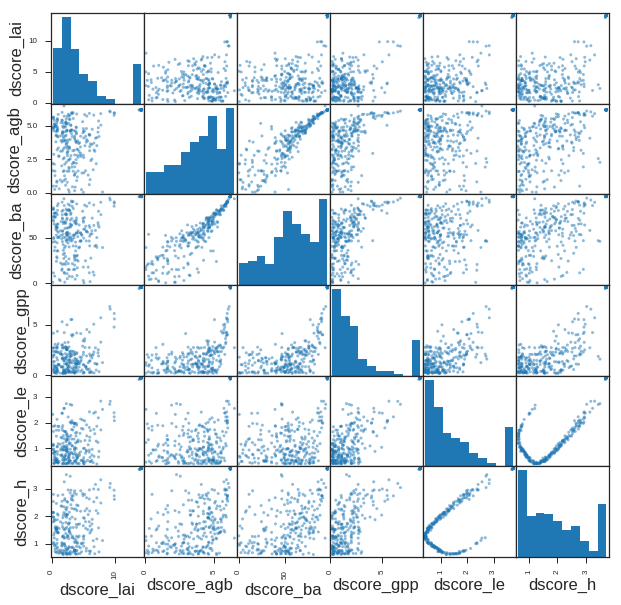

In [23]:
# View as scatter matrix
#pd.scatter_matrix(df, figsize=[10,10])
pd.plotting.scatter_matrix(df, figsize=[10,10])
plt.show()

# Calculate Weighted Average Skill Scores Across Variables

#### Pscores

In [24]:
#Define Weighted Average Functions for averaging scores across variables

# Define weighted average favoring LAI, AGB, and BA (our structural properties)
def wavg_strct(lai_score,agb_score,ba_score,gpp_score,le_score,h_score):
    w = 0.3
    score_wavg_strct = ( w*(lai_score) 
             + w*(agb_score) 
             + w*(ba_score)
             + (1-3*w)*((gpp_score)+ (le_score) + (h_score))/3)
    return score_wavg_strct


# Alternative weightings:
# 1. Weighted average giving greatest weight to LAI, then to combination of AGB and BA (which are correlated with one another),
# and small weight to fluxes which are correlated with one another and with LAI.
def wavg_corr(lai_score,agb_score,ba_score,gpp_score,le_score,h_score):
    w1 = 0.4
    w2 = 0.25
    w3 = 0.1
    score_wavg_corr = ( w1*(lai_score) 
             + w2*(agb_score) 
             + w2*(ba_score)
             + w3*((gpp_score)+ (le_score) + (h_score))/3)
    return score_wavg_corr


# 2. Weighted average with even weighting across all variables
def wavg_even(lai_score,agb_score,ba_score,gpp_score,le_score,h_score):
    w = 1/6
    score_wavg_even = w*(lai_score) + w*(agb_score) + w*(ba_score) + w*(gpp_score)+ w*(le_score) + w*(h_score)
    return score_wavg_even
    
# 3. Weighted average favoring LAI, AGB, and BA but less heavily (average fluxes as one variable)
def wavg_avgflx(lai_score,agb_score,ba_score,gpp_score,le_score,h_score):
    w = 1/4
    score_wavg_avgflx = w*(lai_score) + w*(agb_score) + w*(ba_score) + w*((gpp_score+le_score+h_score)/3)
    return score_wavg_avgflx


# Weighted Average Pscore for each Ensemble member (Favoring LAI, AGB, and BA)
# With 10% Degradation
dg10ind = 1 # (1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_strct_dg10 = wavg_strct(pscore_lai[:,dg10ind],pscore_agb[:,dg10ind],pscore_ba[:,dg10ind],pscore_gpp[:,dg10ind],pscore_le[:,dg10ind],pscore_h[:,dg10ind])

# With 20% Degradation
dg20ind = 2 # (2 =20% degradation, 1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_strct_dg20 = wavg_strct(pscore_lai[:,dg20ind],pscore_agb[:,dg20ind],pscore_ba[:,dg20ind],pscore_gpp[:,dg20ind],pscore_le[:,dg20ind],pscore_h[:,dg20ind])


# Alternatively, weighted Average Pscore for each Ensemble member (Favoring LAI and AGB+BA)
# With 10% Degradation
dg10ind = 1 # (1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_corr_dg10 = wavg_corr(pscore_lai[:,dg10ind],pscore_agb[:,dg10ind],pscore_ba[:,dg10ind],pscore_gpp[:,dg10ind],pscore_le[:,dg10ind],pscore_h[:,dg10ind])

# With 20% Degradation
dg20ind = 2 # (2 =20% degradation, 1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_corr_dg20 = wavg_corr(pscore_lai[:,dg20ind],pscore_agb[:,dg20ind],pscore_ba[:,dg20ind],pscore_gpp[:,dg20ind],pscore_le[:,dg20ind],pscore_h[:,dg20ind])

# Alternatively, weighted Average Pscore for each Ensemble member (Evenly weighted)
# With 10% Degradation
dg10ind = 1 # (1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_even_dg10 = wavg_even(pscore_lai[:,dg10ind],pscore_agb[:,dg10ind],pscore_ba[:,dg10ind],pscore_gpp[:,dg10ind],pscore_le[:,dg10ind],pscore_h[:,dg10ind])
# With 20% Degradation
dg20ind = 2 # (2 =20% degradation, 1 = 10% degradation, 0 = no degradation of observed range)
pscore_wavg_even_dg20 = wavg_even(pscore_lai[:,dg20ind],pscore_agb[:,dg20ind],pscore_ba[:,dg20ind],pscore_gpp[:,dg20ind],pscore_le[:,dg20ind],pscore_h[:,dg20ind])


#### Dscores

In [25]:
# Calculate weighted average Distance scores
# Here we use the weighted Euclidean Distance to calculate the distance of model output from the mean observations in multivariate space:
#  Square each variable score before weighting, then take squareroot of the weighted sum;
#  Use the time period that fits model output best (e.g. jan vs sept start)

# Define weighted average favoring LAI, AGB, and BA (our structural properties)
def wavg_strct_sqr_min(lai_score1,lai_score2,agb_score,ba_score,gpp_score1,gpp_score2,le_score1,le_score2,h_score1,h_score2):
    w = 0.3
    score_wavg_strct_sqr_min = np.sqrt(w * (np.fmin(abs(lai_score1[:,0]),abs(lai_score2[:,0])))**2 
                                     + w * (abs(agb_score[:,0]))**2 
                                     + w * (abs(ba_score[:,0]))**2 
                                     + (1-3* w) * ((np.fmin(abs(gpp_score1[:,0]),abs(gpp_score2[:,0])))**2 
                                                  +(np.fmin(abs(le_score1[:,0]),abs(le_score2[:,0])))**2 
                                                  +(np.fmin(abs(h_score1[:,0]),abs(h_score2[:,0])))**2)/3)
    return score_wavg_strct_sqr_min

# Alternative weightings:
# 1. Weighted average giving greatest weight to LAI, then to combination of AGB and BA (which are correlated with one another),
# and small weight to fluxes which are correlated with one another and with LAI.
def wavg_corr_sqr_min(lai_score1,lai_score2,agb_score,ba_score,gpp_score1,gpp_score2,le_score1,le_score2,h_score1,h_score2):
    w1 = 0.4
    w2 = 0.25
    w3 = 0.1
    score_wavg_strct_sqr_min = np.sqrt(w1 * (np.fmin(abs(lai_score1[:,0]),abs(lai_score2[:,0])))**2 
                                     + w2 * (abs(agb_score[:,0]))**2 
                                     + w2 * (abs(ba_score[:,0]))**2 
                                     + w3 * ((np.fmin(abs(gpp_score1[:,0]),abs(gpp_score2[:,0])))**2 
                                                  +(np.fmin(abs(le_score1[:,0]),abs(le_score2[:,0])))**2 
                                                  +(np.fmin(abs(h_score1[:,0]),abs(h_score2[:,0])))**2)/3)
    return score_wavg_strct_sqr_min

# 2. Weighted average with even weighting across all variables
def wavg_even_sqr_min(lai_score1,lai_score2,agb_score,ba_score,gpp_score1,gpp_score2,le_score1,le_score2,h_score1,h_score2):
    w = 1/6
    score_wavg_even_sqr_min = np.sqrt(w * (np.fmin(abs(lai_score1[:,0]),abs(lai_score2[:,0])))**2 
                                     + w * (abs(agb_score[:,0]))**2 
                                     + w * (abs(ba_score[:,0]))**2 
                                     + w * (np.fmin(abs(gpp_score1[:,0]),abs(gpp_score2[:,0])))**2 
                                     + w * (np.fmin(abs(le_score1[:,0]),abs(le_score2[:,0])))**2 
                                     + w * (np.fmin(abs(h_score1[:,0]),abs(h_score2[:,0])))**2)
    return score_wavg_even_sqr_min

# Weighted Average Distance Score (used in analysis below)
dscore_wavg_strct_sqr_min = wavg_strct_sqr_min(dscore_lai_jan,dscore_lai_sept,dscore_agb,dscore_ba,dscore_gpp_jul,dscore_gpp_sept,dscore_le_jul,dscore_le_sept,dscore_h_jul,dscore_h_sept)

# Alternatively, weighted Average Dscore for each Ensemble member (Favoring LAI and AGB+BA)
dscore_wavg_corr_sqr_min = wavg_corr_sqr_min(dscore_lai_jan,dscore_lai_sept,dscore_agb,dscore_ba,dscore_gpp_jul,dscore_gpp_sept,dscore_le_jul,dscore_le_sept,dscore_h_jul,dscore_h_sept)

# Alternatively, weighted Average Dscore for each Ensemble member (Even weighting)
dscore_wavg_even_sqr_min = wavg_even_sqr_min(dscore_lai_jan,dscore_lai_sept,dscore_agb,dscore_ba,dscore_gpp_jul,dscore_gpp_sept,dscore_le_jul,dscore_le_sept,dscore_h_jul,dscore_h_sept)

# Rank ensemble members by their skill scores.
We try this in a number of ways, each relying on different average score weightings. Then, we select the ensemble members that rank in the top 10 regardless of score weighting, level of pscore range degradation, and CO2 concentration.

# 1. Rank ensemble members using Pscore (10% Degradation) and Dscore, with weighting favoring structural properties LAI, AGB, and BA.

In [26]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
# we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_strct_dg10
dscore_avg = dscore_wavg_strct_sqr_min

rank_pscore = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores given to the best performers
sum_ranks_d10_strct = np.nansum(np.stack([rank_pscore,rank_dscore]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst = np.argsort(sum_ranks_d10_strct)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94, 258,  85,  84, 150, 212,  57,   6,  49])

# 2. Rank ensemble members using Pscore (20% Degradation) and Dscore, with weighting favoring structural properties LAI, AGB, and BA.

In [28]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_strct_dg20
dscore_avg = dscore_wavg_strct_sqr_min
# kscore_avg = 
# tscore_avg = 

rank_pscore_d20 = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_d20_strct = np.nansum(np.stack([rank_pscore_d20,rank_dscore]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_d20 = np.argsort(sum_ranks_d20_strct)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst_d20)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94,  85, 150,  57, 245,  10, 258, 125,   6])

# 3. Rank ensemble members using Pscore (10% Degradation) and Dscore, giving greatest weight to LAI, then to combination of AGB and BA

In [30]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_corr_dg10
dscore_avg = dscore_wavg_corr_sqr_min

rank_pscore_d10_corr = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore_corr = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_d10_corr = np.nansum(np.stack([rank_pscore_d10_corr,rank_dscore_corr]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_d10_corr = np.argsort(sum_ranks_d10_corr)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst_d10_corr)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94, 258,  85,  84, 150, 212,   6, 236,  81])

# 4. Rank ensemble members using Pscore (20% Degradation) and Dscore, giving greatest weight to LAI, then to combination of AGB and BA

In [32]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_corr_dg20
dscore_avg = dscore_wavg_corr_sqr_min

rank_pscore_d20_corr = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore_corr = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_d20_corr = np.nansum(np.stack([rank_pscore_d20_corr,rank_dscore_corr]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_d20_corr = np.argsort(sum_ranks_d20_corr)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst_d20_corr)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94,  85, 150,  57, 245,  10, 258,   6, 124])

# 5. Rank ensemble members using Pscore (10% Degradation) and Dscore, evenly weighting all variables

In [34]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_even_dg10
dscore_avg = dscore_wavg_even_sqr_min

rank_pscore_d10_even = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore_even = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_d10_even = np.nansum(np.stack([rank_pscore_d10_even,rank_dscore_even]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_d10_even = np.argsort(sum_ranks_d10_even)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst_d10_even)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94,  84,  85, 212,  57, 150,  49, 154,  36])

# 6. Rank ensemble members using Pscore (20% Degradation) and Dscore, evenly weighting all variables

In [36]:
# Calculate Ranking for each Pscore and Dscore

# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

# Specify which version of the weighted average scores to use in the ranking
pscore_avg = pscore_wavg_even_dg20
dscore_avg = dscore_wavg_even_sqr_min

rank_pscore_d20_even = scipy.stats.rankdata((100-pscore_avg),method='min')
rank_dscore_even = scipy.stats.rankdata(dscore_avg,method='min')

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_d20_even = np.nansum(np.stack([rank_pscore_d20_even,rank_dscore_even]),axis=0)
# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_d20_even = np.argsort(sum_ranks_d20_even)

print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
# Print Index # for Top 10 Ensemble Members
np.transpose(FEindx_SortBest2Worst_d20_even)[:10,]

Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)


array([259,  94,  85, 150,  57,  10, 245, 124, 258, 125])

# 7. Rank ensemble members incorporating their rankings across all Pscore and Dscore Combinations (#1-6 above)

In [39]:
# Save each sum of ranks for use in script that evaluates each parameter set across ranks and CO2 levels
# Note: rankdata assigns a rank of 1 to the lowest number
# For dscores, a low number (e.g. 0) is a good score and deserves a low ranking.
# For pscores, a high number (e.g. 100) is a good score so
#     we have to calculate 100-pscore before taking the rank so that a pscore of 100 recieves a rank of 1

if setcase == 1:
    sum_ranks_allcombi_367ppm = np.stack([sum_ranks_d10_strct,
                                        sum_ranks_d20_strct,
                                        sum_ranks_d10_corr,
                                        sum_ranks_d20_corr,
                                        sum_ranks_d10_even,
                                        sum_ranks_d20_even])
    np.save('sum_ranks_allcombi_367ppm.npy', sum_ranks_allcombi_367ppm) # saves to folder containing this script
    
elif setcase == 2:
    sum_ranks_allcombi_400ppm = np.stack([sum_ranks_d10_strct,
                                        sum_ranks_d20_strct,
                                        sum_ranks_d10_corr,
                                        sum_ranks_d20_corr,
                                        sum_ranks_d10_even,
                                        sum_ranks_d20_even])
    np.save('sum_ranks_allcombi_400ppm.npy', sum_ranks_allcombi_400ppm) # saves to folder containing this script
    #np.load('sum_ranks_allcombi_400ppm.npy') 

# Sum ranks across weightings and 10% vs 20% extension of observational limits
# We want to sum ranks across all combinations of Dscore and Pscore variations (these have been calculated above and named the following)
# Strct Weighted Dscore and Pscore (10%) = sum_ranks_d10_strct
# Strct Weighted Dscore and Pscore (20%) = sum_ranks_d20_strct
# Corr Weighted Dscore and Pscore (10%) = sum_ranks_d10_corr
# Corr Weighted Dscore and Pscore (20%) = sum_ranks_d20_corr
# Evenly Weighted Dscore and Pscore (10%) = sum_ranks_d10_even
# Evenly Weighted Dscore and Pscore (20%) = sum_ranks_d20_even

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
# NOTE: the following is for this CO2 concentration only (set by setcase). 
#       To get the overall best performers across CO2 concentrations, we use script _________.ipynb
sum_ranks_all_caseCO2 = np.nansum(np.stack([sum_ranks_d10_strct,
                                    sum_ranks_d20_strct,
                                    sum_ranks_d10_corr,
                                    sum_ranks_d20_corr,
                                    sum_ranks_d10_even,
                                    sum_ranks_d20_even]),axis=0)

# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_caseCO2 = np.argsort(sum_ranks_all_caseCO2)

# Print Index # for Top 10 Ensemble Members
print("Index # for Top 10 Ensemble Members for THIS CO2 CONCENTRATION (add 1 to get enesemble member #)")
np.transpose(FEindx_SortBest2Worst_caseCO2)[:10,]


Index # for Top 10 Ensemble Members for THIS CO2 CONCENTRATION (add 1 to get enesemble member #)


array([259,  94,  85, 150, 258,  84, 212,  57, 125, 124])

# Plot Skill Scores of Top 10 Performing Ensemble Members
#  Across all CO2 levels, weighting, and limit extension combinations

#### 1. Calculate Top Performing Ensemble Members across all CO2 levels, weighting, and obs limit extension combinations
This will require running this script up to this point for both CO2 concentrations so that you have generated both sum_ranks_allcombi_367ppm.pyb and sum_ranks_allcombi_400ppm.pyb

In [40]:
# Load sum of ranks from each CO2 combination and weighting scheme
sum_ranks_allcombi_367ppm = np.load('sum_ranks_allcombi_367ppm.npy') 
sum_ranks_allcombi_400ppm = np.load('sum_ranks_allcombi_400ppm.npy')

# Sum ranks across weightings and 10% vs 20% extension of observational limits and CO2 levels
# We want to sum ranks across all combinations of Dscore and Pscore variations
# Each CO2 concentration variable above (sum_ranks_allcombi_---ppm) contains the following:
# Strct Weighted Dscore and Pscore (10%) = sum_ranks_d10_strct
# Strct Weighted Dscore and Pscore (20%) = sum_ranks_d20_strct
# Corr Weighted Dscore and Pscore (10%) = sum_ranks_d10_corr
# Corr Weighted Dscore and Pscore (20%) = sum_ranks_d20_corr
# Evenly Weighted Dscore and Pscore (10%) = sum_ranks_d10_even
# Evenly Weighted Dscore and Pscore (20%) = sum_ranks_d20_even

# Take the sum of the ranks for each ensemble member
#    with low scores = best performers
sum_ranks_ALL = np.nansum(np.concatenate([sum_ranks_allcombi_367ppm,sum_ranks_allcombi_400ppm]),axis=0)
# and the average sum of ranks across ranking methods
avg_sum_ranks_ALL = sum_ranks_ALL/24 # 24 is the number of rankings combined across metrics (2; dscore and pscore); 

# Sort the index # for each ensemble member by sum_rank (best to worst scores)
FEindx_SortBest2Worst_ALL = np.argsort(sum_ranks_ALL)

# Save Top 10 across CO2 levels for use in fates_ensemble benchmarking
np.save('sum_ranks_ALL.npy', sum_ranks_ALL)
np.save('FEindx_SortBest2Worst_ALL.npy', FEindx_SortBest2Worst_ALL)

# Print Index # for Top 10 Ensemble Members
print("Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)")
print(np.transpose(FEindx_SortBest2Worst_ALL)[:10,])

print("")

print("Sum of ranks for Top 10 Ensemble Members:")
print(sum_ranks_ALL[FEindx_SortBest2Worst_ALL[:10,]])

print("")

print("Avg sum of ranks for Top 10 Ensemble Members:")
print(avg_sum_ranks_ALL[FEindx_SortBest2Worst_ALL[:10,]])



Index # for Top 10 Ensemble Members (add 1 to get enesemble member #)
[ 85 259 150  94 124  84 258   6  36  10]

Sum of ranks for Top 10 Ensemble Members:
[110 128 164 303 328 329 382 471 497 521]

Avg sum of ranks for Top 10 Ensemble Members:
[ 4.58333333  5.33333333  6.83333333 12.625      13.66666667 13.70833333
 15.91666667 19.625      20.70833333 21.70833333]


#### 2. Plot Heatmaps of Skill Scores for Top 10 Performers and All ensemble members

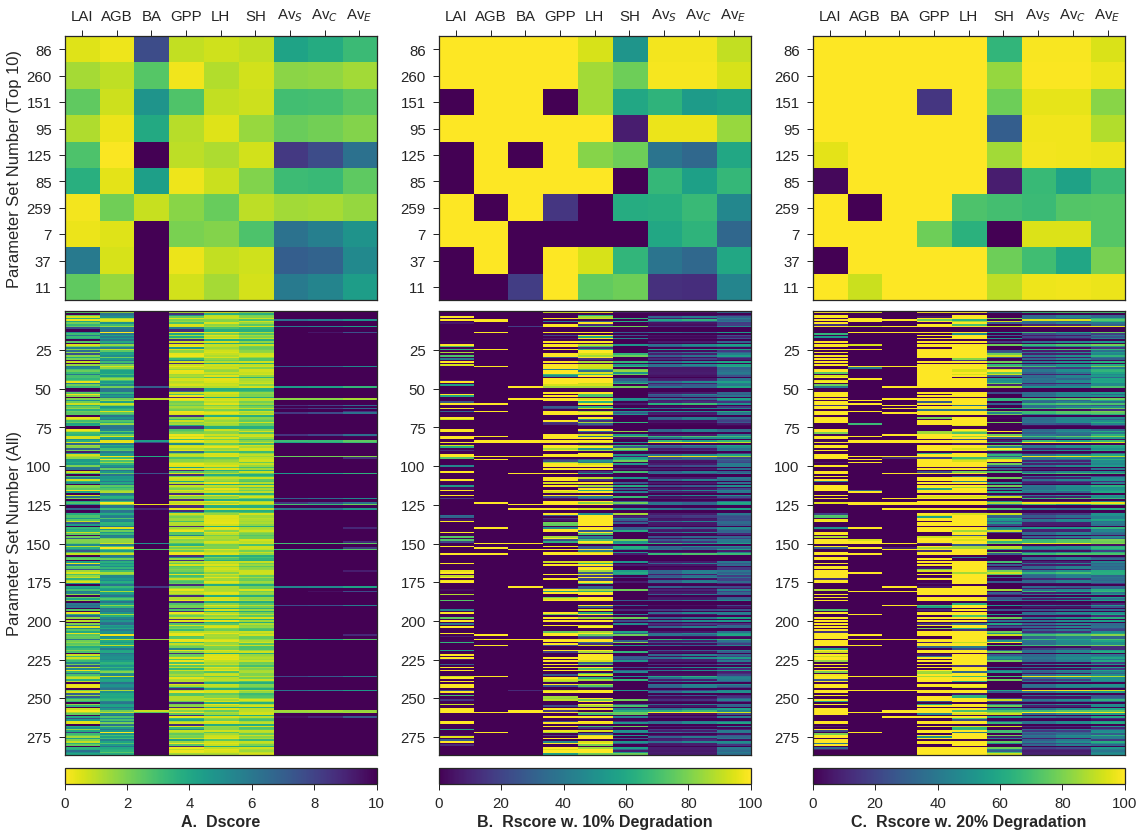

In [41]:
#Indices for Overall Top 10 Performers:
OverallTop10FEindx = np.transpose(FEindx_SortBest2Worst_ALL)[:10,] # indices of top 10 performers calculated across CO2, weightings, and Pscore extensions in cell above
# Ensemble member Number for Top 10 Performers (use for labels)
OverallTop10FEnum = OverallTop10FEindx + np.ones(np.array(OverallTop10FEindx).shape)

# We want the following variables:

# Best Pscore (10%, 20%) and Dscore for individual variables: LAI, AGB, BA, GPP, LH, SH
# Weighted Avg Pscore (10%, 20%) and Dscore: Strct, Corr, Even for this CO2 level

# LAI
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_lai[OverallTop10FEindx,1] # Pscore 10% (0 = none, 1= 10%, 2 = 20%)
#pscore_lai[OverallTop10FEindx,2] # Pscore 20%
#dscore_lai_best[OverallTop10FEindx] #= np.fmin(abs(dscore_lai_jan[:,0]),abs(dscore_lai_sept[:,0]))

# AGB
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_agb[OverallTop10FEindx,1]
#pscore_agb[OverallTop10FEindx,2]
#dscore_agb[OverallTop10FEindx] # = np.squeeze(dscore_agb[:,0])

# BA
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_ba[OverallTop10FEindx,1]
#pscore_ba[OverallTop10FEindx,2]
#dscore_ba[OverallTop10FEindx] #= np.squeeze(dscore_ba[:,0])

# GPP
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_gpp[OverallTop10FEindx,1]
#pscore_gpp[OverallTop10FEindx,2]
#dscore_gpp_best[OverallTop10FEindx] #=np.fmin(abs(dscore_gpp_jul[:,0]),abs(dscore_gpp_sept[:,0]))

# LE
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_le[OverallTop10FEindx,1]
#pscore_le[OverallTop10FEindx,2]
#dscore_le_best[OverallTop10FEindx] #= np.fmin(abs(dscore_le_jul[:,0]),abs(dscore_le_sept[:,0]))

# SH
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_h[OverallTop10FEindx,1]
#pscore_h[OverallTop10FEindx,2]
#dscore_h_best[OverallTop10FEindx] # = np.fmin(abs(dscore_h_jul[:,0]),abs(dscore_h_sept[:,0]))

# Weighted Avg Score (Strct), for 10% and 20% degradation of observational limits
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_wavg_strct_dg10[OverallTop10FEindx]
#pscore_wavg_strct_dg20[OverallTop10FEindx]
#dscore_wavg_strct_sqr_min[OverallTop10FEindx]

# Weighted Avg Score (Corr), for 10% and 20% degradation of observational limits
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_wavg_corr_dg10[OverallTop10FEindx]
#pscore_wavg_corr_dg20[OverallTop10FEindx]
#dscore_wavg_corr_sqr_min[OverallTop10FEindx]

# Weighted Avg Score (Even), for 10% and 20% degradation of observational limits
# Following each had Shape (287,), then we selected top 10, now have Shape (10,)
#pscore_wavg_even_dg10[OverallTop10FEindx] 
#pscore_wavg_even_dg20[OverallTop10FEindx] 
#dscore_wavg_even_sqr_min[OverallTop10FEindx]



#Heatmap Data

pscore10_heatdata_all = (np.stack((
    # LAI
    pscore_lai[:,1],  # Pscore 10% degradation
    # AGB
    pscore_agb[:,1], # Pscore 10% degradation
    # BA
    pscore_ba[:,1],  # Pscore 10% degradation
    # GPP
    pscore_gpp[:,1],    # Pscore 10% degradation
    # LE
    pscore_le[:,1],    # Pscore 10% degradation
    # SH
    pscore_h[:,1],    # Pscore 10% degradation
    # Weighted Avg Score (Strct)
    pscore_wavg_strct_dg10,     # Pscore 10% degradation
    # Weighted Avg Score (Corr)
    pscore_wavg_corr_dg10,    # Pscore 10% degradation
    # Weighted Avg Score (Even)
    pscore_wavg_even_dg10),     # Pscore 10% degradation
    axis=1))

pscore20_heatdata_all = (np.stack((
    # LAI
    pscore_lai[:,2],  # Pscore 20%
    # AGB
    pscore_agb[:,2], # Pscore 20%
    # BA
    pscore_ba[:,2],  # Pscore 20%
    # GPP
    pscore_gpp[:,2],    # Pscore 20%
    # LE
    pscore_le[:,2],    # Pscore 20%
    # SH
    pscore_h[:,2],    # Pscore 20%
    # Weighted Avg Score (Strct)
    pscore_wavg_strct_dg20,     # Pscore 20% degradation
    # Weighted Avg Score (Corr)
    pscore_wavg_corr_dg20,    # Pscore 20%
    # Weighted Avg Score (Even)
    pscore_wavg_even_dg20),  # Pscore 20%
    axis=1))
                  

dscore_heatdata_all = (np.stack((
    # LAI
    dscore_lai_best, # Dscore, best of two start dates
    # AGB
    np.squeeze(dscore_agb),   # Dscore
    # BA
    np.squeeze(dscore_ba),    # Dscore
    # GPP
    dscore_gpp_best, # Dscore, best of two start dates
    # LE
    dscore_le_best, # Dscore, best of two start dates
    # SH
    dscore_h_best, # Dscore, best of two start dates
    # Weighted Avg Score (Strct)
    dscore_wavg_strct_sqr_min,  # Dscore
    # Weighted Avg Score (Corr)
    dscore_wavg_corr_sqr_min, # Dscore
    # Weighted Avg Score (Even)
    dscore_wavg_even_sqr_min),  # Dscore  
    axis=1))

score_labels = [
       "LAI",
       "AGB",
       "BA",
       "GPP",
       "LH",
       "SH",
       "Av$_{S}$",
       "Av$_{C}$",
       "Av$_{E}$"]

                   
# Create Figure
fig = plt.figure(figsize=(16,12))

# font size for labels
fsz = 16

# Y-axis labels 
# for Top 10
ens10 = [str(int(x)) for x in OverallTop10FEnum]
# for All
enslist = [str(x) for x in range(25,300,25)] # Label every 25th ens member
ens = np.array(range(25,300,25))

# Plot Dscore for top 10
ax1 = plt.subplot(3,3,1)
im1 = ax1.imshow(dscore_heatdata_all[OverallTop10FEindx],vmin = 0, vmax = 10,cmap="viridis_r",aspect='auto')
# Create colorbar
#cbar1 = ax1.figure.colorbar(im1, ax=ax1,orientation="horizontal", pad=0.025)
#cbar1.ax.set_xlabel('Dscore')

#ax.set_xlabel('Observations (Ann Mean)')
ax1.set_xticks(np.arange(len(score_labels)))
ax1.xaxis.tick_top()
ax1.set_xticklabels(score_labels)
ax1.xaxis.set_label_position('top')

ax1.set_ylabel('Parameter Set Number (Top 10)')
ax1.set_yticks(np.arange(len(ens10)))
ax1.set_yticklabels(ens10)


# Plot Dscore for all
ax4 = plt.subplot(3,3,(4,7))
im4 = ax4.imshow(dscore_heatdata_all,vmin = 0, vmax = 10,cmap="viridis_r",aspect='auto')
# Create colorbar
cbar4 = ax1.figure.colorbar(im4, ax=ax4,orientation="horizontal", pad=0.025)
cbar4.ax.set_xlabel('A.  Dscore', fontsize = fsz, fontweight ='bold')

#ax.set_xlabel('Observations (Ann Mean)')
#ax4.set_xticks(np.arange(len(score_labels))) # to show xticks/labels
ax4.set_xticks([]) # to hide xticks/labels
#ax4.xaxis.tick_top()
#ax4.set_xticklabels(score_labels)
#ax4.xaxis.set_label_position('top')

ax4.set_ylabel('Parameter Set Number (All)')
ax4.set_yticks(ens)
ax4.set_yticklabels(enslist)



# Plot Pscore 10% for top 10
ax2 = plt.subplot(3,3,2)
im2 = ax2.imshow(pscore10_heatdata_all[OverallTop10FEindx],vmin = 0, vmax = 100,cmap="viridis",aspect='auto')
# Create colorbar
#cbar2 = ax2.figure.colorbar(im2, ax=ax2,orientation="horizontal", pad=0.025)
#cbar2.ax.set_xlabel('Rscore w. 10% Degradation')

#ax1.set_xlabel('Observations (Ann Mean)')
ax2.set_xticks(np.arange(len(score_labels)))
ax2.xaxis.tick_top()
ax2.set_xticklabels(score_labels)
ax2.xaxis.set_label_position('top')

#ax2.set_ylabel('Parameter Set Number')
ax2.set_yticks(np.arange(len(ens10)))
ax2.set_yticklabels(ens10)

# Plot Pscore 10% for all
ax5 = plt.subplot(3,3,(5,8))
im5 = ax5.imshow(pscore10_heatdata_all,vmin = 0, vmax = 100,cmap="viridis",aspect='auto')
# Create colorbar
cbar5 = ax5.figure.colorbar(im5, ax=ax5,orientation="horizontal", pad=0.025)
cbar5.ax.set_xlabel('B.  Rscore w. 10% Degradation', fontsize = fsz, fontweight ='bold')

#ax5.set_xlabel('Observations (Ann Mean)')
#ax5.set_xticks(np.arange(len(score_labels))) # to show xticks/labels
ax5.set_xticks([]) # to hide xticks/labels
#ax5.xaxis.tick_top()
#ax5.set_xticklabels(score_labels)
#ax5.xaxis.set_label_position('top')

#ax5.set_ylabel('Parameter Set Number')
ax5.set_yticks(ens)
ax5.set_yticklabels(enslist)



# Plot Pscore 20% for top 10
ax3 = plt.subplot(3,3,3)
im3 = ax3.imshow(pscore20_heatdata_all[OverallTop10FEindx],vmin = 0, vmax = 100,cmap="viridis",aspect='auto')
# Create colorbar
#cbar3 = ax.figure.colorbar(im3, ax=ax3,orientation="horizontal", pad=0.025)
#cbar3.ax.set_xlabel('Rscore w. 20% Degradation')

#ax3.set_xlabel('Observations (Ann Mean)')
ax3.set_xticks(np.arange(len(score_labels)))
ax3.xaxis.tick_top()
ax3.set_xticklabels(score_labels)
ax3.xaxis.set_label_position('top')

#ax3.set_ylabel('Parameter Set Number')
ax3.set_yticks(np.arange(len(ens10)))
ax3.set_yticklabels(ens10)


# Plot Pscore 20% for all
ax6 = plt.subplot(3,3,(6,9))
im6 = ax6.imshow(pscore20_heatdata_all,vmin = 0, vmax = 100,cmap="viridis",aspect='auto')
# Create colorbar
cbar6 = ax.figure.colorbar(im6, ax=ax6,orientation="horizontal", pad=0.025)
cbar6.ax.set_xlabel('C.  Rscore w. 20% Degradation', fontsize = fsz, fontweight ='bold')

#ax.set_xlabel('Observations (Ann Mean)')
#ax6.set_xticks(np.arange(len(score_labels))) # to show xticks/labels
ax6.set_xticks([]) # to hide xticks/labels
#ax6.xaxis.tick_top()
#ax6.set_xticklabels(score_labels)
#ax6.xaxis.set_label_position('top')

#ax6.set_ylabel('Parameter Set Number')
ax6.set_yticks(ens)
ax6.set_yticklabels(enslist)

set

plt.tight_layout()
fig.subplots_adjust(hspace=0.04) # reduce space between subplots in the height direction


In [42]:
# save image
#fig.savefig(save_plot_as_OverallHeatmap, bbox_inches='tight') 

<Figure size 720x720 with 0 Axes>

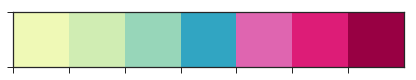

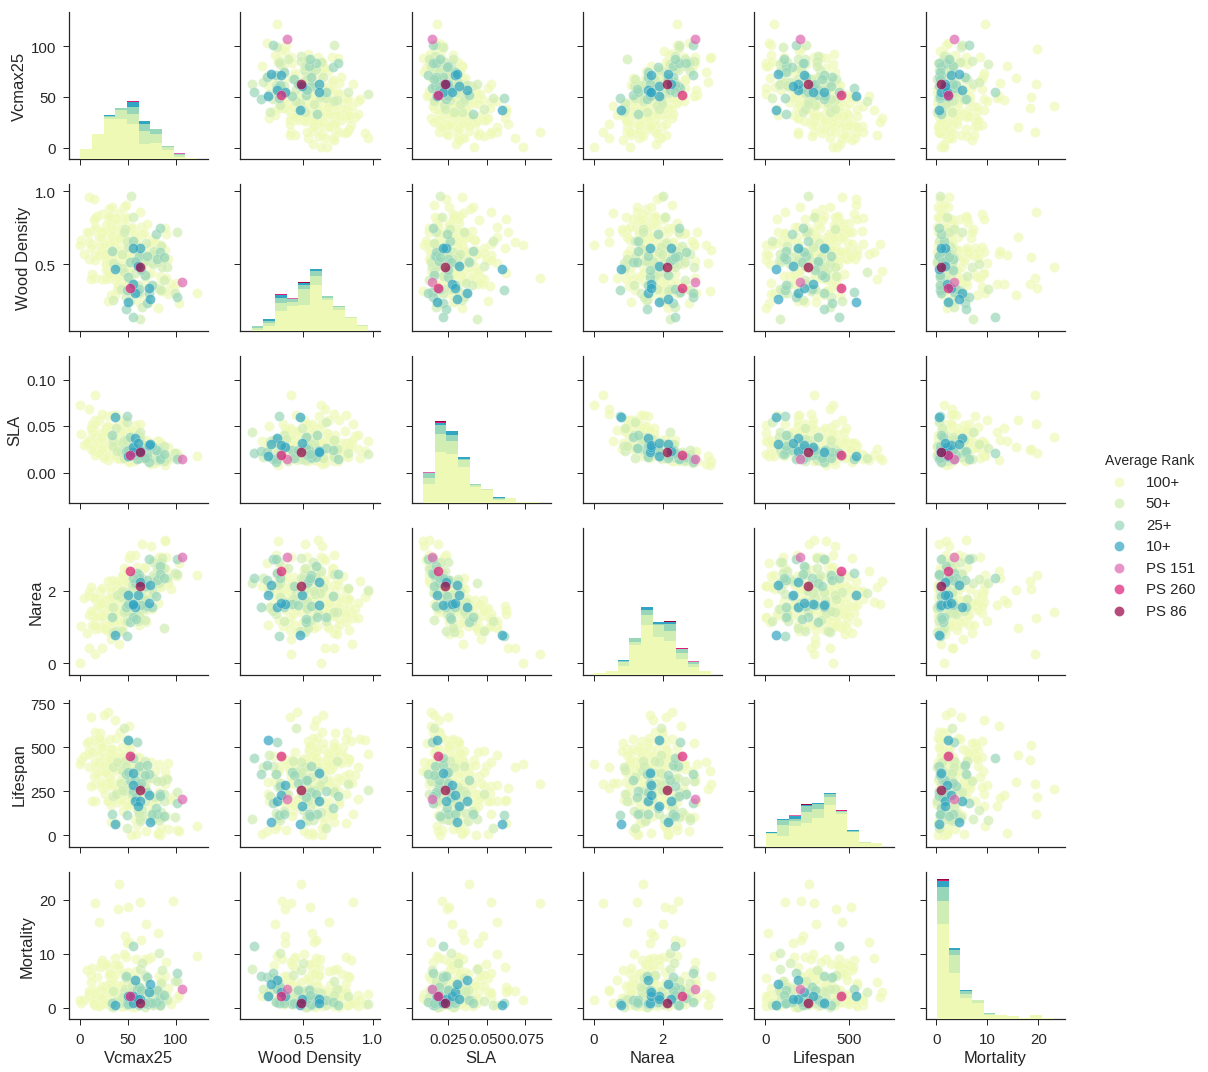

In [53]:
# Same as above but plots only variables for which we have observations
# Plot each ensemble member's average ranks ALL (sum_of_ranks_ALL/number of rankings)
# Load trait data
traits_matrix = np.loadtxt('/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/traits_matrix_used_in_param_files_180717.txt')
# Convert LMA values in the original traits_matrix to SLA values, as was done in Charlie Koven's script to set slatop
# slatop = 1/(LMA*carbonfraction_mean) # gC/m2
traits_matrix[:,2] = 1/(traits_matrix[:,2]*.4482)

# Plot only subset of traits: those we have observations for (vcmax to mortality)
traits_matrix = traits_matrix[:,:6]
column_names = ['Vcmax25', 'Wood Density', 'SLA', 'Narea','Lifespan','Mortality']
ncols = len(column_names)
df_traits = pd.DataFrame(traits_matrix, columns=column_names)


# Load the sum of ranks data
# Here we take the negative values so that low ranks (better performers) are plotted last (on top), 
# otherwise they are covered by poor performers.
# We change the labels back to positive values below.
#df_traits["avg_sum_ranks"] = pd.cut(-1*avg_sum_ranks_ALL, bins=[-260,-200,-100,-50,-25,-10,-6,-5,0]) # more bins
df_traits["avg_sum_ranks"] = pd.cut(-1*avg_sum_ranks_ALL, bins=[-260,-100,-50,-25,-10,-6,-5,0])

# Plot onto trait covariance matrix
xsize = 10
ysize = 10
fig = plt.figure(figsize=(xsize,ysize))
ax = plt.gca

# set custom color palette
# To get hex values for an existing palette:
#pal = sns.color_palette("YlGnBu", 8)
#pal.as_hex()

# 1. top = pink shades, rest = green shades
#fe_rankcolor1 = ["#e6f5d0","#b8e186","#7fbc41","#4d9221","#276419","#f768a1","#ae017e","#49006a"]

# 2. top = pink shades, rest = YlGnBu
fe_rankcolor2 = ['#eff9b6','#d0edb3','#97d6b9','#31a5c2',"#df65b0","#dd1c77","#980043"]
#fe_rankcolor2 = ['#eff9b6','#d0edb3','#97d6b9','#5dc0c0','#31a5c2',"#df65b0","#dd1c77","#980043"] # use this one for "more bins"

# Set color pallete for plt here:
sns.set_palette(fe_rankcolor2)
sns.palplot(sns.color_palette())

# Create plot
g1 = sns.pairplot(df_traits, hue="avg_sum_ranks",
                 hue_order=df_traits.avg_sum_ranks.cat.categories,
                 kind="scatter",plot_kws=dict(alpha=0.7,s=100)) # note: can add keyword size to adjut size of plots

# Tried setting SLA xlim but did not work:
#g1.axes[2,:].set_ylim(0,0.1)
#axes[0,0].set_ylim(0,)

# Set ylim for all to 0
#g1.set(ylim=(0, None),xlim=(0, None))

# Update Legend
# title
new_title = 'Average Rank'
g1._legend.set_title(new_title)
# replace labels
new_labels = ['100+','50+','25+','10+','PS 151','PS 260','PS 86']
#new_labels = ['200+','100+','50+','25+','10+','PS 150','PS 259','PS 86'] # use with "more bins"
for t, l in zip(g1._legend.texts, new_labels): t.set_text(l)

In [54]:
# save image
g1.savefig(save_plot_as_skilltraitcovar1)

<Figure size 720x720 with 0 Axes>

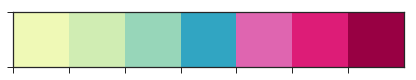

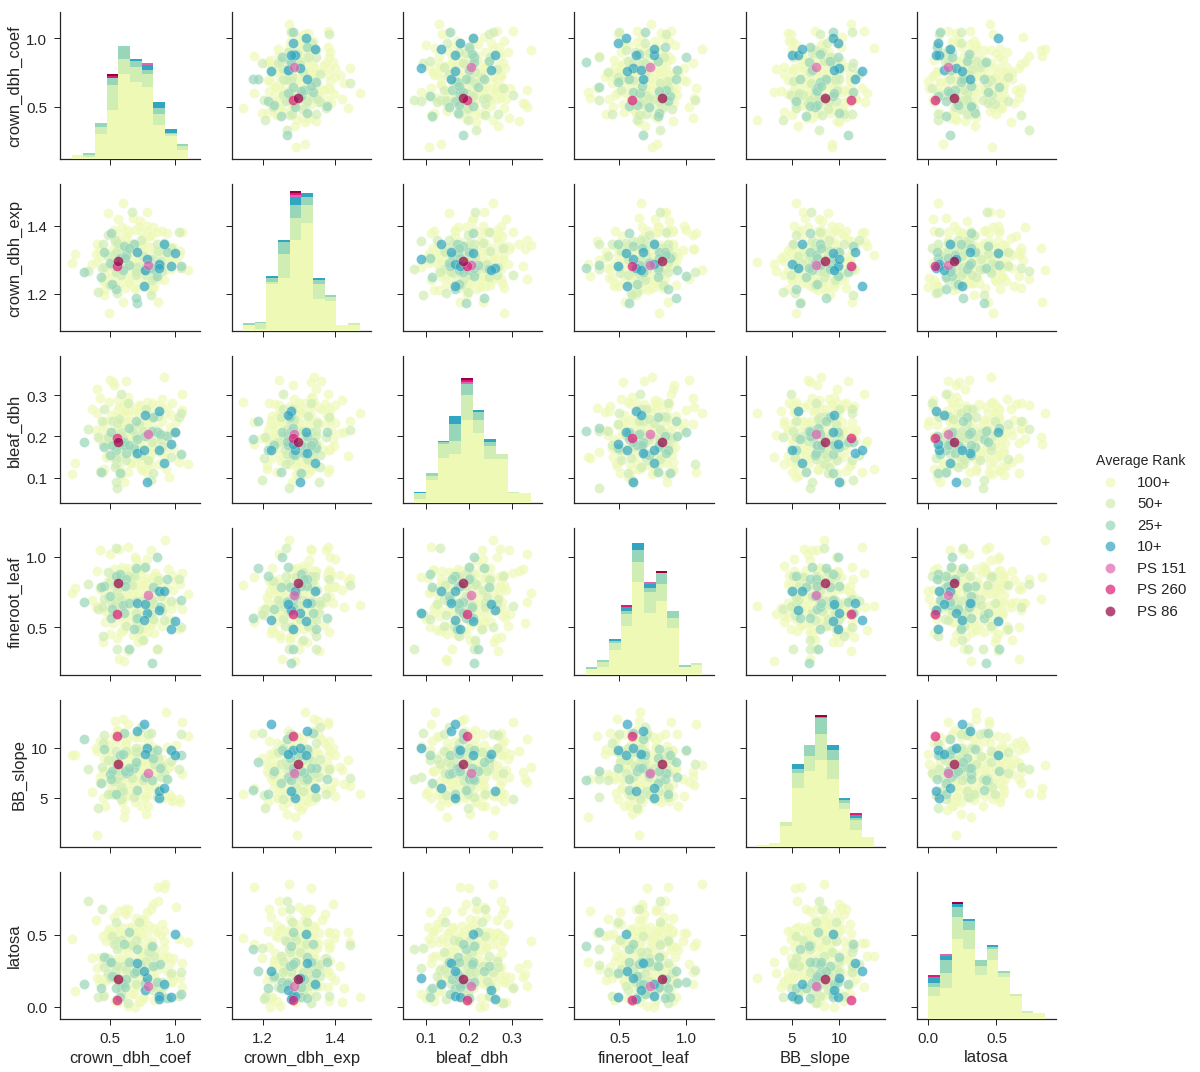

In [55]:
# Same as above but plots only variables for which we do not have observations
# Plot each ensemble member's average ranks ALL (sum_of_ranks_ALL/number of rankings)
# Load trait data
traits_matrix = np.loadtxt('/home/disk/eos3/kovenock/matlab/aim3_fates_lma/fates_output/bci_testbed/traits_matrix_used_in_param_files_180717.txt')

# Plot only subset of traits: those we have observations for (crown_dbh_coef to latosa)
traits_matrix = traits_matrix[:,6:]
column_names = ['crown_dbh_coef','crown_dbh_exp','bleaf_dbh','fineroot_leaf','BB_slope','latosa']
ncols = len(column_names)
df_traits = pd.DataFrame(traits_matrix, columns=column_names)


# Load the sum of ranks data
# Here we take the negative values so that low ranks (better performers) are plotted last (on top), 
# otherwise they are covered by poor performers.
# We change the labels back to positive values below.

#df_traits["avg_sum_ranks"] = pd.cut(-1*avg_sum_ranks_ALL, bins=[-260,-200,-100,-50,-25,-10,-6,-5,0]) # more bins
df_traits["avg_sum_ranks"] = pd.cut(-1*avg_sum_ranks_ALL, bins=[-260,-100,-50,-25,-10,-6,-5,0])

# Plot onto trait covariance matrix
xsize = 10
ysize = 10
fig = plt.figure(figsize=(xsize,ysize))
ax = plt.gca

# set custom color palette
# To get hex values for an existing palette:
#pal = sns.color_palette("YlGnBu", 8)
#pal.as_hex()

# 1. top = pink shades, rest = green shades
#fe_rankcolor1 = ["#e6f5d0","#b8e186","#7fbc41","#4d9221","#276419","#f768a1","#ae017e","#49006a"]

# 2. top = pink shades, rest = YlGnBu
fe_rankcolor2 = ['#eff9b6','#d0edb3','#97d6b9','#31a5c2',"#df65b0","#dd1c77","#980043"]
#fe_rankcolor2 = ['#eff9b6','#d0edb3','#97d6b9','#5dc0c0','#31a5c2',"#df65b0","#dd1c77","#980043"] # use this one for "more bins"

# Set color pallete for plt here:
sns.set_palette(fe_rankcolor2)
sns.palplot(sns.color_palette())

# Create plot
g2 = sns.pairplot(df_traits, hue="avg_sum_ranks",
                 hue_order=df_traits.avg_sum_ranks.cat.categories,
                 kind="scatter",plot_kws=dict(alpha=0.7,s=100)) # note: can add keyword size to adjut size of plots

# Set ylim for all to 0
#g2.set(ylim=(0, None),xlim=(0, None))

# Update Legend
# title
new_title = 'Average Rank'
g2._legend.set_title(new_title)
# replace labels
new_labels = ['100+','50+','25+','10+','PS 151','PS 260','PS 86']
#new_labels = ['200+','100+','50+','25+','10+','PS 150','PS 259','PS 86'] # use with "more bins"
for t, l in zip(g2._legend.texts, new_labels): t.set_text(l)

In [56]:
# save image
g2.savefig(save_plot_as_skilltraitcovar2)